In [22]:
from train import *
from PIL import Image
import glob

In [313]:
import scipy
import scipy.io as sio

def image_process(img_path):
    img_list = glob.glob(img_path)
    img_list.sort()
    images = [np.array((Image.open(img)).resize((64,64))) for img in img_list]
    images = np.array(images)/255
    x_data = np.array(images)
    print(x_data.shape)
    return x_data


def get_latent( subj, f_lat, m_lat, f_data, m_data, DATA_PATH):
    behavior_path= '%s/%s/behavior/data_phase1_run00.mat'%(DATA_PATH, subj)
    behavior_list=[behavior_path.replace('00', str(i)) for i in range(1, 1+10)]
    lat_list=[]
    img_list=[]
    for run, b in enumerate(behavior_list):
        mat = scipy.io.loadmat(b)
        condition=mat['designMat'][1]
        img_gender=mat['designMat'][2][condition==1]
        img_idx=mat['designMat'][3][condition==1]

        for idx, gender in zip(img_idx, img_gender):
            if gender==1: 
                lat_map=f_lat
                img_map=f_data
            else: 
                lat_map=m_lat
                img_map=m_data
            lat = lat_map[int(idx)-1]
            img = img_map[int(idx)-1]
            lat_list.append(lat)
            img_list.append(img)
    return np.array(img_list), np.array(lat_list)

In [143]:
PATH = '/Volumes/Backup Plus/yb/primeRecon'

## Make Dataset

In [144]:
m_data = image_process('%s/vae_train/data/male/0*jpg'%PATH)
f_data = image_process('%s/vae_train/data/female/0*jpg'%PATH)

(706, 64, 64, 3)
(768, 64, 64, 3)


## Use-model

In [76]:
encoder, decoder, vae = build_vae(m_data.shape,100)

In [145]:
encoder.load_weights('%s/vae_train/results/celeba3/encoder.h5'%PATH)
decoder.load_weights('%s/vae_train/results/celeba3/decoder.h5'%PATH)
vae.load_weights('%s/vae_train/results/celeba3/vae.h5'%PATH)

In [146]:
m_lat = encoder.predict_on_batch(m_data)[2]
f_lat = encoder.predict_on_batch(f_data)[2]
m_lat.shape, f_lat.shape
np.save('../fmri_analysis/scripts/f_latent2.npy', f_lat)
np.save('../fmri_analysis/scripts/m_latent2.npy', m_lat)

## Get latent array

In [147]:
f_lat = np.load('../fmri_analysis/scripts/f_latent2.npy')
m_lat = np.load('../fmri_analysis/scripts/m_latent2.npy')
f_lat.shape, m_lat.shape

((768, 100), (706, 100))

In [151]:
for SUBJ in ['sub02', 'sub19', 'sub21', 'sub22', 'sub23', 'sub24']:
    latent = get_latent(SUBJ, f_lat, m_lat, '%s/fmri_analysis/data'%PATH)
    np.save('%s/fmri_analysis/results/%s/regression/y_arr2.npy'%(PATH,SUBJ), latent)

## Make dataset and Regression

In [592]:
from sklearn import linear_model

def _get_rnd_sample(x_sup, x_enh):
    if x_sup.shape[1]<x_enh.shape[1]: return x_sup
    else:
        mask_idx=np.random.choice([i for i in range(x_sup.shape[1])], x_enh.shape[1], replace=False)
        mask_idx.sort()
        mask=[]
        for idx in range(x_sup.shape[1]):
            if idx in mask_idx: mask.append(True)
            else: mask.append(False)

        x_rnd=x_sup[:,mask]

        return x_rnd

def train_and_recon(x_data, y_data):
    x_train, x_test, y_train, y_test = x_data[:950], x_data[950:], y_data[:950], y_data[950:]
    #model = linear_model.Ridge(alpha=0.4)
    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_rec = decoder.predict_on_batch(y_test)
    p_rec = decoder.predict_on_batch(y_pred)
    return y_rec, p_rec

In [518]:
SUBJ = 'sub23'
img, y_data = get_latent(SUBJ, f_lat, m_lat, f_data, m_data, '%s/fmri_analysis/data'%PATH)
x_data = np.load('%s/fmri_analysis/results/%s/regression/x_mask.npy'%(PATH,SUBJ))
x_data.shape, y_data.shape

sup_mask = np.load('%s/fmri_analysis/results/%s/regression/sup_mask.npy'%(PATH,SUBJ))
enh_mask = np.load('%s/fmri_analysis/results/%s/regression/enh_mask.npy'%(PATH,SUBJ))

x_sup = x_data[:, sup_mask==1]
x_enh = x_data[:, enh_mask==1]
x_rnd = _get_rnd_sample(x_sup, x_enh)
x_data.shape, x_sup.shape,  x_rnd.shape, x_enh.shape

((1000, 21395), (1000, 17028), (1000, 4366), (1000, 4366))

In [576]:
y_rec, p_rec = train_and_recon(x_data, y_data)
_, p_sup = train_and_recon(x_sup, y_data)
_, p_rnd = train_and_recon(x_rnd, y_data)
_, p_enh = train_and_recon(x_enh, y_data)

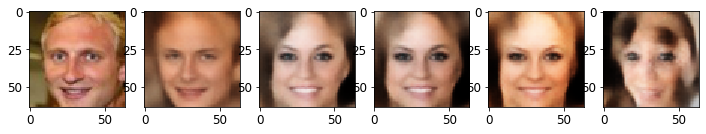

In [591]:
draw_reg(17)

In [555]:
def draw_reg(idx):
    plt.figure(figsize=(12,4))
    plt.subplot(1,6,1)
    plt.imshow(img[950+idx])
    plt.subplot(1,6,2)
    plt.imshow(y_rec[idx])
    plt.subplot(1,6,3)
    plt.imshow(p_rec[idx])
    plt.subplot(1,6,4)
    plt.imshow(p_sup[idx])
    plt.subplot(1,6,5)
    plt.imshow(p_rnd[idx])
    plt.subplot(1,6,6)
    plt.imshow(p_enh[idx])
    plt.show()